<a href="https://colab.research.google.com/github/isb-cgc/Community-Notebooks/blob/master/Volcano_plot_using_CPTAC_protein_expression_of_ovarian_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ISB-CGC Community Notebooks

Check out more notebooks at our [Community Notebooks Repository](https://github.com/isb-cgc/Community-Notebooks)!

```
Title:   Volcano plot using CPTAC protein expression of Ovarian cancer
Author:  Boris Aguilar
Created: 2022-01-30
URL:     https://github.com/isb-cgc/Community-Notebooks/blob/master/Notebooks/Volcano_plot_using_CPTAC_protein_expression_of_ovarian_cancer.ipynb
Purpose: Demostrate how to generate a volcano plot using BigQuery tables of protein expression data.
Notes: 
```
This notebook uses CPTAC BigQuery tables of Ovarian cancer, and generates a Volcano plot similar to that of Figure 3A of [McDermott et al. Cell Rep Med. 2020; 1(1): 100004](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7289043/), a CPTAC paper that analyze proteomics data of Ovarian cancer patients.


## Packages
Load all R package dependencies, installing if necessary.

In [24]:
# BigQuery library
if (!require(bigrquery)) {
  install.packages('bigrquery')
}
# Tidyr package
if (!require('stringr')) {
  install.packages('stringr')
}
# Tidyr package
if (!require('stringr')) {
  install.packages('stringr')
}
# Scales package to support visualization
if (!require('ggplot2')) {
  install.packages('ggplot2')
}

# edgeR to support analysis
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("edgeR")

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.rstudio.com


Bioconductor version 3.14 (BiocManager 1.30.16), R 4.1.2 (2021-11-01)

Warning message:
“package(s) not installed when version(s) same as current; use `force = TRUE` to
  re-install: 'edgeR'”
Old packages: 'broom', 'cli', 'dtplyr', 'fansi', 'generics', 'gert', 'glue',
  'jsonlite', 'magrittr', 'pillar', 'Rcpp', 'readr', 'rlang', 'testthat',
  'tidyr', 'yaml', 'class', 'foreign', 'MASS', 'nlme', 'nnet', 'rpart',
  'spatial'



## Authenticate to Access BigQuery
Before using BigQuery, we need to get authorization for access to BigQuery and the Google Cloud. For more information see ['Quick Start Guide to ISB-CGC'](https://isb-cancer-genomics-cloud.readthedocs.io/en/latest/sections/HowToGetStartedonISB-CGC.html). R notebooks that use the BigRQuery library need the following work-around to authenticate. See the following link: https://gist.github.com/jobdiogenes/235620928c84e604c6e56211ccf681f0

In [25]:
# NOTE: this cell is only required if you're using Google Colab
if (!require('R.utils')) {
    install.packages("R.utils")
}
if (!require('httr')) {
    install.pckages('httr')
}

my_check <- function() {return(TRUE)}
reassignInPackage("is_interactive", pkgName = "httr", my_check) 
options(rlang_interactive=TRUE)

In [26]:
# Now authenticate to BQ. Be sure to select the BigQuery scope!
bq_auth(use_oob = TRUE, cache = FALSE)

Please point your browser to the following url: 

https://accounts.google.com/o/oauth2/auth?client_id=603366585132-dpeg5tt0et3go5of2374d83ifevk5086.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code



Enter authorization code: 4/1AX4XfWj7TJVtVWLVdRWMVtYUubnqsDpCqmvNqbBxk5G4NV1lriR5iCKJwOQ


## Libraries

In [27]:
library(bigrquery)
library(stringr)
library(ggplot2)
library(edgeR)
library(tidyr)
project <- 'cgc-05-0042' # Write your google project id here.

## Retrieve Data

These commands create a query that joins two tables, one that contains protein expression from Ovarian cancer patients (isb-cgc-bq.CPTAC.quant_proteome_prospective_ovarian_PNNL_qeplus_pdc_current) and another table that contains  information of patient samples ( isb-cgc-bq.PDC_metadata.aliquot_to_case_mapping_current). This query retrieve sample type (cancerous or normal), gene names (gene_symbol), and protein expression or abundance. 

In [28]:
sql1 <- "
SELECT IF( sample_type = 'Primary Tumor', 
           CONCAT('C', meta.case_submitter_id), 
           CONCAT('N', meta.case_submitter_id)) AS case_submitter_id, 
       quan.gene_symbol, 
       protein_abundance_log2ratio as abundance
FROM `isb-cgc-bq.CPTAC.quant_proteome_prospective_ovarian_PNNL_qeplus_pdc_current` as quan
JOIN `isb-cgc-bq.PDC_metadata.aliquot_to_case_mapping_current` as meta
        ON quan.case_id = meta.case_id
        AND quan.aliquot_id = meta.aliquot_id
        AND meta.project_name = 'CPTAC2 Confirmatory'
ORDER BY case_submitter_id
"

The following commands retrieve the desired information from the cloud

In [29]:
unpivot_tbl <- bq_project_query (project, query = sql1) #Put data in temporary BQ table
unpivot_data <- bq_table_download(unpivot_tbl) #Put data into a dataframe
head(unpivot_data)

case_submitter_id,gene_symbol,abundance
<chr>,<chr>,<dbl>
C01OV007,LOC105369247,-0.3350
C01OV007,LOC101060405,NaN
C01OV007,CYTB,0.0043
C01OV007,COX1,0.0838
C01OV007,COX2,-0.4224
C01OV007,COX3,0.0888


BigQuery tables typically have tidy format. For this analysis, we need to pivot the table such that each column corresponds to sample ids (case_submitter_id). Then we delete rows (genes) with NA values.

In [30]:
df = spread(unpivot_data, case_submitter_id,  abundance)
row_table <- df  %>%  drop_na

Following the same procedure specified by [McDermott et al. Cell Rep Med. 2020; 1(1): 100004](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7289043/), we delete the data from sample N17OV001 and average the protein abundance for each gene

In [31]:
mydf = subset( df, select = -c( N17OV001) )
agg_df = aggregate(.~gene_symbol, mydf, mean)

Then we set the gene names (gene_symbol column) as index of the dataframe.

In [32]:
agg_pdf <- agg_df[,-1]
rownames(agg_pdf) <- agg_df[,1]
head(agg_pdf)

,C01OV007,C01OV017,C01OV018,C01OV023,C01OV026,C01OV029,C01OV030,C01OV039,C01OV041,C01OV047,⋯,N01OV039,N11OV002,N11OV010,N14OV011,N14OV029,N15OV001,N17OV002,N17OV003,N17OV004,N17OV005
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A1BG,-0.0310,-0.3964,-0.6135,0.8268,-0.5403,-0.9771,-0.1226,-1.1519,-0.4095,0.0970,⋯,0.9657,1.6826,1.6522,0.1598,2.0637,1.4634,1.5573,1.0918,0.7167,1.5052
A2M,0.4694,-0.4366,-0.1953,0.9754,0.1521,-0.4794,-0.3090,-0.6133,-0.4618,-0.1532,⋯,0.5141,1.1342,0.9555,0.9163,2.9083,1.8210,1.3842,2.9949,1.7822,1.4131
A2ML1,-0.5561,-0.6267,-0.1352,-0.3891,-3.0901,-0.8589,-1.7998,-0.9436,-1.7904,0.4066,⋯,3.9666,-0.8844,-1.2389,-0.4644,0.0300,0.9456,0.7569,0.0314,2.7622,0.0927
AAAS,0.2473,0.1387,-0.0843,0.2441,0.4030,0.0325,0.0675,0.8106,0.3457,0.2091,⋯,-0.4465,-0.0680,-0.2249,-0.1383,-0.3704,-0.3378,-0.0801,0.1995,-0.3542,-0.0646
AACS,0.0028,0.5439,0.6288,0.0261,0.1816,-0.5467,-0.0955,0.9098,-0.3147,0.4041,⋯,-0.1535,-0.4677,-0.1221,0.8530,0.1151,-0.2599,0.6305,-0.2490,1.2992,0.5415
AAGAB,0.0807,0.4445,0.1813,0.4318,0.0144,-0.0186,0.0646,-0.5741,-0.0465,0.1827,⋯,-0.3292,-0.3167,-0.1110,-0.4485,-0.4659,-0.0342,-0.4440,0.0227,-0.3950,-0.6133


Finally, we are ready to use edgeR to compute protein expression differences and statistical measures. 

In [33]:
cnames = colnames(agg_pdf) #102 - 18
fac = factor(rep( c("tumor","normal"), c(84,18) )) # #[1:83] 
fit <- lmFit(agg_pdf, design=model.matrix(~ fac))

colnames(coef(fit))

[1] "(Intercept)" "factumor"

In [34]:
fit <- eBayes(fit)

In [35]:
tt <- topTable(fit, n=Inf, coef=2)
tt_high1 <- topTable(fit, n=Inf, coef=2, lfc = 0.5)
tt_high2 <- topTable(fit, n=Inf, coef=2, lfc = 1.0)

head(tt)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
OGN,-3.747109,-0.88427647,-16.57358,5.494037e-31,3.767811e-27,59.90879
ITGA7,-2.304933,-0.10680196,-15.65745,3.835328e-29,1.315134e-25,55.73648
LAMB2,-1.964599,0.06163922,-15.44381,1.047863e-28,2.125728e-25,54.74794
SYNM,-3.121135,-0.68622941,-15.40816,1.239853e-28,2.125728e-25,54.58244
CDH13,-2.476388,-0.13725588,-15.26327,2.460712e-28,3.186168e-25,53.90805
SOD3,-2.781924,-0.31016275,-15.23697,2.787549e-28,3.186168e-25,53.78534


Finally, the following steps generate the volcano plot. The following link provides a detailed explanation of the steps to generate Volcano plots: https://wiki.bits.vib.be/index.php/Tutorial:_Testing_for_differential_expression_I


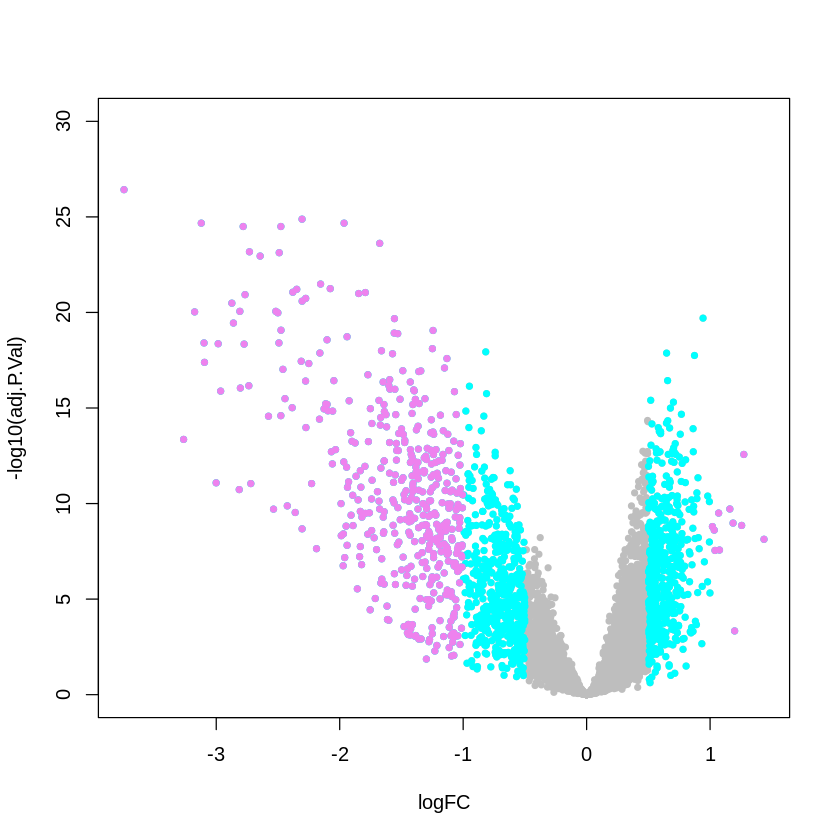

In [36]:
plot(-log10(adj.P.Val) ~ logFC, data=tt, pch=20  , ylim=c(0,30 ), col = 'grey') 
points(-log10(adj.P.Val) ~ logFC, data=tt_high1, pch=20, col="cyan")
points(-log10(adj.P.Val) ~ logFC, data=tt_high2, pch=20, col="violet")

Thi plot is very similar to Figure 3A of [McDermott et al. Cell Rep Med. 2020; 1(1): 100004](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7289043/) which is  Volcano plot representation of differential protein expression in tumor versus normal samples of Ovarian cancer patiens of the CPTAC project.